In [2]:
from common import *

In [3]:
# Load dataset
def gen_data():
    for size in [100, 200, 300, 400, 500]:
        for classifier in ['DL (Drift)', 'Statistical']:
            respath = ROC_PATH / classifier.split()[0] / 'exp01'
            if classifier.startswith('DL'):
                respath = respath / 'drift'
            item = pd.read_csv(respath / f'subsampled_ROC_{size}.txt', sep=' ', names=['TPR', 'FPR'])
            item['Classifier'] = classifier
            item['Num packets'] = size
            yield item

data = pd.concat(gen_data()).reset_index(drop=True)

In [4]:
def get_num_packets(N, alpha=0.05, tpr=0.9):
    lim = (alpha * tpr) / (alpha + N * (1 - alpha) - 1)
    valid_fprs = data[data.FPR <= lim]
    data_sorted = valid_fprs.sort_values(['Classifier', 'Num packets', 'FPR'], ascending=False)
    data_sorted = data_sorted.groupby(['Classifier', 'Num packets']).head(1).drop(columns=['FPR'])
    result = data_sorted[data_sorted.TPR > tpr].groupby('Classifier').tail(1)
    st_packets = result[result.Classifier == 'Statistical']['Num packets']
    nn_packets = result[result.Classifier == 'DL (Drift)']['Num packets']
    st_packets = int(st_packets) if len(st_packets) > 0 else None
    nn_packets = int(nn_packets) if len(nn_packets) > 0 else None
    return st_packets, nn_packets

In [5]:
def get_xy_values(alpha, tpr):
    st_values, nn_values = [], []
    for N in 10 ** np.arange(6):
        st_value, nn_value = get_num_packets(1 + N, alpha, tpr)
        if st_value is not None:
            st_values.append((N, st_value))
        if nn_value is not None:
            nn_values.append((N, nn_value))
    print(st_values, nn_values)
    return st_values, nn_values

In [19]:
def fit_and_plot(values, color='red', marker='v', linestyle='--', label='50% confidence'):
    x, y = zip(*values)
    def func(x, a, b, c):
        return a * np.log10(b * x) + c
    popt, pcov = curve_fit(func, x, y)
    g = sns.scatterplot(x=x, y=y, color=color, marker=marker, s=100, legend=False, palette='bright')
    l = np.linspace(10, 100000000, 100)
    plt.plot(l, func(l, *popt), color=color, alpha=1, linestyle=linestyle, label=label)
    return g

[(1, 100), (10, 200), (100, 300), (1000, 400), (10000, 500)] [(1, 100), (10, 200), (100, 300), (1000, 400), (10000, 500)]
[(1, 100), (10, 200), (100, 300), (1000, 400), (10000, 500)]


/Users/mjuarez/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mjuarez/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `precision-crop.pdf'.


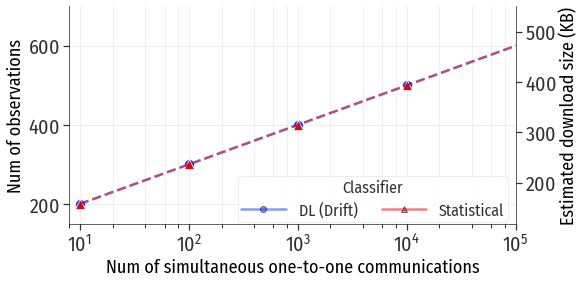

In [20]:
fig = plt.gcf()
fig.set_size_inches(8, 4)

alpha, tpr = 0.05, 0.95
st_values, nn_values = get_xy_values(alpha, tpr)

print(nn_values)
g = fit_and_plot(nn_values, color=blue, marker='o', label='>95% confidence')
g = fit_and_plot(st_values, color=red, marker='^', label='>95% confidence')

g.set(xlabel='Num of simultaneous one-to-one communications\n',
      ylabel='Num of observations',
      xscale='log',
      ylim=(150, 700),
      xlim=(8, 1e5));
plt.setp(g.lines, alpha=.5)

# force minor log ticks
g.set_xscale('log')
g.set_xticks([10, 100, 1000, 1e4, 1e5])
locmin = LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8), numticks=12)
g.xaxis.set_minor_locator(locmin)
g.xaxis.set_minor_formatter(NullFormatter())


handles = [Line2D([0], [0], marker='o', alpha=0.5, color=blue),
           Line2D([0], [0], marker='^', alpha=0.5, color=red)]
plt.legend(handles=handles, labels=['DL (Drift)', 'Statistical'], title='Classifier',
           bbox_to_anchor=(0.68, 0.01), loc='lower center', borderaxespad=0, borderpad=0.2, ncol=2)
plt.grid(True, which="both", ls="-", alpha=0.2)
secax = g.secondary_yaxis('right', functions=(lambda x: (x * 1611) / 2048, lambda x: (x * 2048) / 1611))
secax.set_ylabel('Estimated download size (KB)');

plt.savefig('precision.pdf', dpi=300, bbox_inches='tight')

! pdfcrop --margin 0 precision.pdf
! mv precision-crop.pdf precision.pdf